<a href="https://colab.research.google.com/github/AIDA-DA/aida-project-image-scene/blob/main/notebooks/Project_Image_Scene_Classification_Visualisation.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

<img src="https://storage.googleapis.com/kaggle-datasets-images/130081/310927/007f156e945286c81911147dd952ad22/dataset-cover.jpg?t=2019-03-02-09-45-36" width="100%">
<center><h1>AIDA Final Project</h1></center>
<center><p>Image Scene Classification - Visualisation</p></center>

We will use [this](https://www.kaggle.com/puneet6060/intel-image-classification) Kaggle dataset which contains 25k images of the 6 categories. Our goal is to develop an algorithm which can distinguish the different image categories. I this approach I will use Tensorflow Keras together with pretained models provided by the framework.

In [ ]:
import tensorflow as tf
import numpy as np
import os
import matplotlib.pyplot as plt

In [ ]:
from tensorflow.keras.models import load_model

### Download & Prepare Dataset

In [ ]:
from google.colab import drive 
drive.mount('/content/drive', force_remount=True)

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.activity.readonly&response_type=code

Enter your authorization code:



ValueError: ignored

Download the artist dataset using the Kaggle API. In order to use the Kaggle’s public API, you must first authenticate using an API token. From the site header, click on your user profile picture, then on “My Account” from the dropdown menu. This will take you to your account settings at https://www.kaggle.com/account. Scroll down to the section of the page labelled API:

To create a new token, click on the “Create New API Token” button. This will download a fresh authentication token onto your machine. Upload `kaggle.json` into Google Colab Files

In [ ]:
os.environ["KAGGLE_CONFIG_DIR"] = "/content"
os.chmod("/content", 600)
os.chmod("/content/kaggle.json", 600)

or set username and API-Key as enviroment variables

```
os.environ['KAGGLE_USERNAME'] = 'paulbauriegel'
os.environ['KAGGLE_KEY'] = '...'
```

Authenticate and Download Dataset from Kaggle

In [ ]:
from kaggle.api.kaggle_api_extended import KaggleApi
api = KaggleApi()
api.authenticate()

In [ ]:
api.dataset_download_files('puneet6060/intel-image-classification', unzip=True)

In [ ]:
images_dir = '/content/seg_train/seg_train'
class_names = sorted(os.listdir(images_dir))
n_classes = len(class_names)

### Visualisation

In [ ]:
import itertools
from collections import Counter

In [ ]:
from tensorflow.keras.preprocessing import image_dataset_from_directory
image_generator = image_dataset_from_directory(images_dir, 
                                               batch_size=1, 
                                               image_size=(150, 150),
                                               label_mode='categorical',
                                               class_names=class_names)

Found 14034 files belonging to 6 classes.


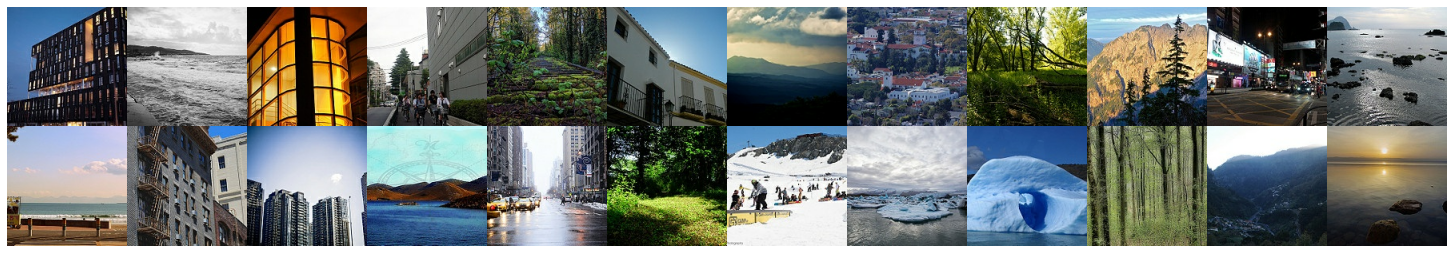

In [ ]:
fig = plt.figure(figsize=(20, 3.32))
for i, (image, label) in enumerate(image_generator):
  ax = plt.subplot(2, 12, i + 1)
  ax.imshow(image[0].numpy().astype('int'))
  ax.axis("off")
  if i==23:
    break
fig.subplots_adjust(wspace=0, hspace=0, left=0, right=1, top=1, bottom=0)

#### Class Distibution

In [ ]:
l = []
for class_name in os.listdir(images_dir):
  l+= [os.path.join(class_name, x) for x in os.listdir(os.path.join(images_dir, class_name))]
l_y = [x.split('/')[0] for x in l]

In [ ]:
Counter(l_y)

Counter({'buildings': 2191,
         'forest': 2271,
         'glacier': 2404,
         'mountain': 2512,
         'sea': 2274,
         'street': 2382})

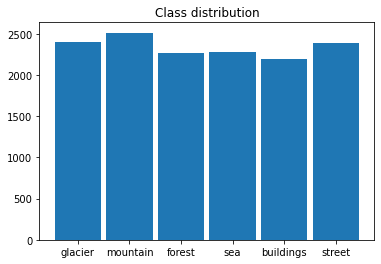

In [ ]:
plt.hist(l_y, 
         bins=np.array([0, 1, 2, 3, 4, 5, 6])-0.5, rwidth=0.9)
plt.title('Class distribution');

### Load best model

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [110]:
model = load_model('/content/drive/MyDrive/model_resnet_kfold_ensembe.h5')
model.trainable = False

5
Predicted class = street
Prediction probability = 79.02550101280212 %


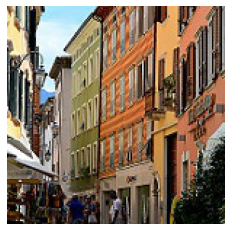

In [57]:
import imageio
import cv2

img = imageio.imread('/content/seg_test/seg_test/street/20066.jpg')
web_image = cv2.resize(img, dsize=(150, 150)).astype('float')
web_image /= 255.
web_image = np.expand_dims(web_image, axis=0)

prediction = model.predict(web_image)
prediction_probability = np.amax(prediction)
prediction_idx = np.argmax(prediction)
print(prediction_idx)

print("Predicted class =", class_names[prediction_idx].replace('_', ' '))
print("Prediction probability =", prediction_probability*100, "%")

plt.imshow(img)
plt.axis('off')
plt.show()

In [64]:
class_names = ['glacier','mountain','forest','sea','buildings','street']

In [65]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from sklearn.metrics import classification_report, confusion_matrix, roc_curve, auc, roc_auc_score

In [66]:
batch_size = 196
preprocess_gen = ImageDataGenerator(rescale=1./255.)
val_gen = preprocess_gen.flow_from_directory(
    directory='/content/seg_test/seg_test',
    class_mode='categorical',
    target_size=(150, 150),
    batch_size=batch_size,
    shuffle=False,
    classes=class_names)

Found 3000 images belonging to 6 classes.


In [67]:
Y_pred = model.predict(val_gen)
y_pred = np.argmax(Y_pred, axis=1)

Confusion Matrix

In [77]:
import seaborn as sns
import pandas as pd

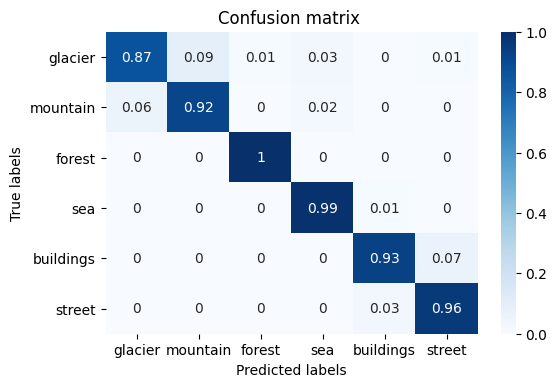

In [92]:
cm = np.around(confusion_matrix(val_gen.classes, y_pred, normalize='true'), 2)
figure = plt.figure(dpi=100)
sns.heatmap(cm, annot=True,cmap=plt.cm.Blues,
            xticklabels=class_names, yticklabels=class_names)
plt.xlabel("Predicted labels")
plt.ylabel("True labels")
plt.title('Confusion matrix ')
plt.show()

Classification Report

In [95]:
import io

In [103]:
report = classification_report(val_gen.classes, y_pred, 
                               target_names=class_names, output_dict=True)
pd.DataFrame(report).transpose().round(2)

,precision,recall,f1-score,support
glacier,0.94,0.87,0.90,553.00
mountain,0.90,0.92,0.91,525.00
forest,0.98,1.00,0.99,474.00
sea,0.95,0.99,0.97,510.00
buildings,0.95,0.93,0.94,437.00
street,0.93,0.96,0.95,501.00
accuracy,0.94,0.94,0.94,0.94
macro avg,0.94,0.94,0.94,3000.00
weighted avg,0.94,0.94,0.94,3000.00


In [70]:
from sklearn.preprocessing import LabelBinarizer

0.9657406630163486

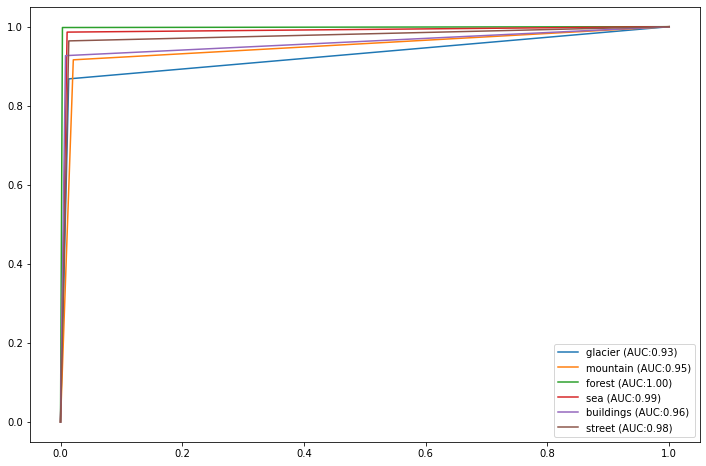

In [72]:
# set plot figure size
fig, c_ax = plt.subplots(1,1, figsize = (12, 8))

def multiclass_roc_auc_score(y_test, y_pred, average="macro"):
    lb = LabelBinarizer()
    lb.fit(y_test)
    y_test = lb.transform(y_test)
    y_pred = lb.transform(y_pred)

    for (idx, c_label) in enumerate(class_names): # all_labels: no of the labels, for ex. ['cat', 'dog', 'rat']
        fpr, tpr, thresholds = roc_curve(y_test[:,idx].astype(int), y_pred[:,idx])
        c_ax.plot(fpr, tpr, label = '%s (AUC:%0.2f)'  % (c_label, auc(fpr, tpr)))
    plt.legend()
    return roc_auc_score(y_test, y_pred, average=average)

multiclass_roc_auc_score(val_gen.classes, y_pred)

Top losses

In [106]:
import tensorflow.keras.backend as K

In [111]:
n_images = len(val_gen.classes)
loss = n_images*[None]

for image, label in val_gen:

    # note I'll use the same input for x & y parameters which is the case for an autoencoder
    loss[i] = model.evaluate(image,
                             label,
                             batch_size=None,
                             verbose=0,
                             steps=1
                             )
predict = model.predict(batch)
loss = MSE(batch,predict)

KeyboardInterrupt: ignored

GradCAM

In [115]:
!git clone https://github.com/tabayashi0117/Score-CAM

Cloning into 'Score-CAM'...
remote: Enumerating objects: 31, done.
remote: Counting objects: 100% (31/31), done.
remote: Compressing objects: 100% (26/26), done.
remote: Total 85 (delta 8), reused 26 (delta 5), pack-reused 54
Unpacking objects: 100% (85/85), done.


In [1]:
from tensorflow.keras.preprocessing.image import load_img
from tensorflow.keras.models import load_model
from tensorflow.keras.applications.vgg16 import VGG16, decode_predictions
import matplotlib.pyplot as plt
import cv2
import numpy as np
from gradcamutils import GradCam, GradCamPlusPlus, ScoreCam, build_guided_model, GuidedBackPropagation, superimpose, read_and_preprocess_img

In [2]:
model = load_model('/content/drive/MyDrive/model_ftv2_RN50.h5')
model.trainable = False

In [25]:
img_path = '/content/seg_test/seg_test/street/20931.jpg'#'/content/seg_test/seg_test/forest/20056.jpg'
orig_img = np.array(load_img(img_path),dtype=np.uint8)
img_array = read_and_preprocess_img(img_path, size=(224,224))

predictions = model.predict(img_array)
print(predictions)

[[1.5671811e-10 4.3379252e-05 2.1287734e-09 1.0524097e-08 6.6630091e-03
  9.9329364e-01]]


In [26]:
layer_name = 'conv5_block3_3_conv'
model.get_layer(layer_name).output

<tf.Tensor 'conv5_block3_3_conv_2/BiasAdd:0' shape=(None, 7, 7, 2048) dtype=float32>

/content/gradcamutils.py:61: RuntimeWarning: invalid value encountered in true_divide
  alphas /= alpha_normalization_constant.reshape((1,1,conv_first_grad_0.shape[2]))


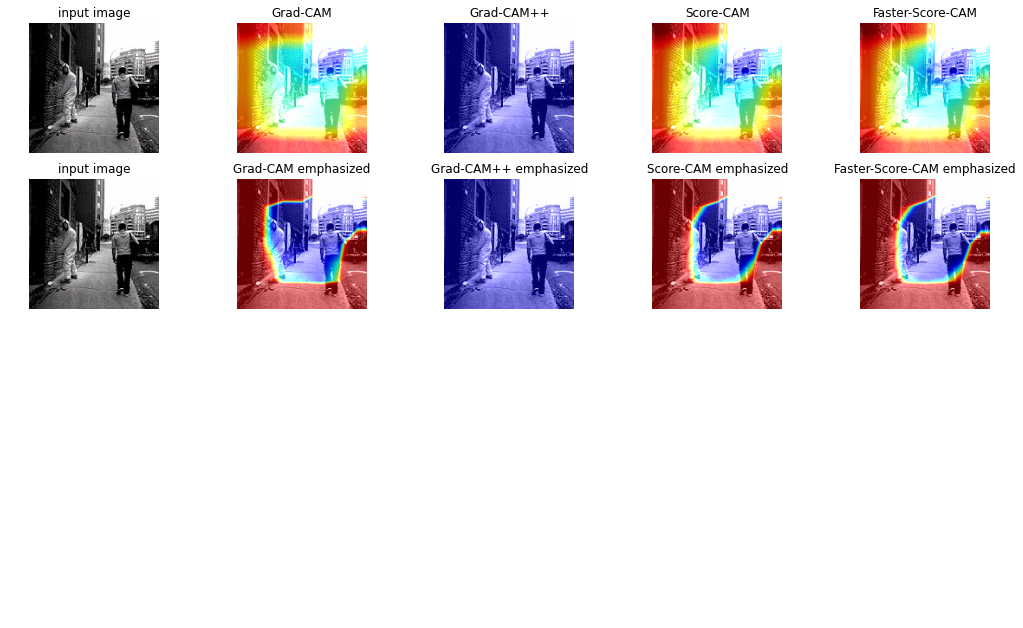

In [27]:
grad_cam=GradCam(model,img_array,layer_name)
grad_cam_superimposed = superimpose(img_path, grad_cam)
grad_cam_emphasized = superimpose(img_path, grad_cam, emphasize=True)

grad_cam_plus_plus=GradCamPlusPlus(model,img_array,layer_name)
grad_cam_plus_plus_superimposed = superimpose(img_path, grad_cam_plus_plus)
grad_cam_plus_plus_emphasized = superimpose(img_path, grad_cam_plus_plus, emphasize=True)

score_cam=ScoreCam(model,img_array,layer_name)
score_cam_superimposed = superimpose(img_path, score_cam)
score_cam_emphasized = superimpose(img_path, score_cam, emphasize=True)

faster_score_cam=ScoreCam(model,img_array,layer_name, max_N=10)
faster_score_cam_superimposed = superimpose(img_path, faster_score_cam)
faster_score_cam_emphasized = superimpose(img_path, faster_score_cam, emphasize=True)

"""
guided_model = build_guided_model(model)
saliency = GuidedBackPropagation(guided_model, img_array, layer_name)
saliency_resized = cv2.resize(saliency, (orig_img.shape[1], orig_img.shape[0]))

grad_cam_resized = cv2.resize(grad_cam, (orig_img.shape[1], orig_img.shape[0]))
guided_grad_cam = saliency_resized * grad_cam_resized[..., np.newaxis]

grad_cam_plus_plus_resized = cv2.resize(grad_cam_plus_plus, (orig_img.shape[1], orig_img.shape[0]))
guided_grad_cam_plus_plus = saliency_resized * grad_cam_plus_plus_resized[..., np.newaxis]

score_cam_resized = cv2.resize(score_cam, (orig_img.shape[1], orig_img.shape[0]))
guided_score_cam = saliency_resized * score_cam_resized[..., np.newaxis]

faster_score_cam_resized = cv2.resize(score_cam, (orig_img.shape[1], orig_img.shape[0]))
guided_faster_score_cam = saliency_resized * faster_score_cam_resized[..., np.newaxis]
"""
img_gray = cv2.imread(img_path, 0)
dx = cv2.Sobel(img_gray, cv2.CV_64F, 1, 0, ksize=3)
dy = cv2.Sobel(img_gray, cv2.CV_64F, 0, 1, ksize=3)
grad = np.sqrt(dx ** 2 + dy ** 2)  
grad = cv2.dilate(grad,kernel=np.ones((5,5)), iterations=1)
grad -= np.min(grad)
grad /= np.max(grad)  # scale 0. to 1.

#grad_times_grad_cam = grad * grad_cam_resized
#grad_times_grad_cam_plus_plus = grad * grad_cam_plus_plus_resized
#grad_times_score_cam = grad * score_cam_resized
#grad_times_faster_score_cam = grad * faster_score_cam_resized

fig, ax = plt.subplots(nrows=4,ncols=5, figsize=(18, 11))
ax[0,0].imshow(orig_img)
ax[0,0].set_title("input image")
ax[0,1].imshow(grad_cam_superimposed)
ax[0,1].set_title("Grad-CAM")
ax[0,2].imshow(grad_cam_plus_plus_superimposed)
ax[0,2].set_title("Grad-CAM++")
ax[0,3].imshow(score_cam_superimposed)
ax[0,3].set_title("Score-CAM")
ax[0,4].imshow(faster_score_cam_superimposed)
ax[0,4].set_title("Faster-Score-CAM")
ax[1,0].imshow(orig_img)
ax[1,0].set_title("input image")
ax[1,1].imshow(grad_cam_emphasized)
ax[1,1].set_title("Grad-CAM emphasized")
ax[1,2].imshow(grad_cam_plus_plus_emphasized)
ax[1,2].set_title("Grad-CAM++ emphasized")
ax[1,3].imshow(score_cam_emphasized)
ax[1,3].set_title("Score-CAM emphasized")
ax[1,4].imshow(faster_score_cam_emphasized)
ax[1,4].set_title("Faster-Score-CAM emphasized")
"""
ax[2,0].imshow(saliency_resized)
ax[2,0].set_title("Guided-BP")
ax[2,1].imshow(guided_grad_cam)
ax[2,1].set_title("Guided-Grad-CAM")
ax[2,2].imshow(guided_grad_cam_plus_plus)
ax[2,2].set_title("Guided-Grad-CAM++")
ax[2,3].imshow(guided_score_cam)
ax[2,3].set_title("Guided-Score-CAM")
ax[2,4].imshow(guided_faster_score_cam)
ax[2,4].set_title("Guided-Faster-Score-CAM")
ax[3,0].imshow(grad, 'gray')
ax[3,0].set_title("grad")
ax[3,1].imshow(grad_times_grad_cam, 'gray')
ax[3,1].set_title("grad * Grad-CAM")
ax[3,2].imshow(grad_times_grad_cam_plus_plus, 'gray')
ax[3,2].set_title("grad * Grad-CAM++")
ax[3,3].imshow(grad_times_score_cam, 'gray')
ax[3,3].set_title("grad * Score-CAM")
ax[3,4].imshow(grad_times_faster_score_cam, 'gray')
ax[3,4].set_title("grad * Faster-Score-CAM")
"""
for i in ax.flatten():
    i.axis('off')
plt.show()

In [21]:
!git clone https://github.com/eclique/keras-gradcam

fatal: destination path 'keras-gradcam' already exists and is not an empty directory.
